In [ ]:
# DON'T RUN STEP 4 AND 5 THE TRANSLATION IS ALREADY DONE
# Install necessary libraries
import pandas as pd
# !pip install googletrans
from googletrans import Translator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Initialize translator object
translator = Translator()

# Step 1: Load the dataset
file_path = '/content/data_tshikama_xls-1 (1)(2).xlsx'
df = pd.read_excel(file_path)

# Step 2: Data Cleaning and Preprocessing
# 2.1: Remove rows with missing values in critical columns
df.dropna(subset=['FRANCAIS', 'SENTIMENT'], inplace=True)

# 2.2: Convert text to lowercase for consistency
df['FRANCAIS'] = df['FRANCAIS'].str.lower()

# 2.3: Remove special characters from 'FRANCAIS' column (optional, depending on dataset)
df['FRANCAIS'] = df['FRANCAIS'].str.replace('[^\w\s]', '', regex=True)

# 2.4: Remove duplicates
df.drop_duplicates(inplace=True)

# 2.5: Standardize the sentiment labels (if they are inconsistent)
sentiment_mapping = {'Positif': 'Positive', 'Négatif': 'Negative', 'Neutre': 'Neutral'}
df['SENTIMENT'] = df['SENTIMENT'].map(sentiment_mapping)

# 2.6: Map sentiment labels to numeric values for classification tasks
sentiment_numeric_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['SENTIMENT_NUMERIC'] = df['SENTIMENT'].map(sentiment_numeric_mapping)

In [ ]:
# Step 3: Translate French to English
def translate_french_to_english(french_text):
    try:
        result = translator.translate(french_text, src='fr', dest='en')
        if result and result.text:
            return str(result.text)  # Ensure the result is always a string
        else:
            return french_text  # fallback to original French word if translation fails
    except Exception as e:
        print(f"Error translating {french_text}: {e}")
        return french_text  # fallback to original text in case of error

# Apply translation to the 'FRANCAIS' column
df['ENGLISH'] = df['FRANCAIS'].apply(translate_french_to_english)

In [ ]:
# Step 4: Translate English to Afrikaans and Zulu
def translate_to_language(english_text, target_lang):
    try:
        result = translator.translate(english_text, src='en', dest=target_lang)
        if result and result.text:
            return str(result.text)  # Ensure the result is a string
        else:
            return english_text  # fallback to original English word if translation fails
    except Exception as e:
        print(f"Error translating {english_text} to {target_lang}: {e}")
        return english_text  # fallback to original text in case of error

# Apply translation for Afrikaans and Zulu
df['AFRIKAANS'] = df['ENGLISH'].apply(translate_to_language, target_lang='af')
df['ZULU'] = df['ENGLISH'].apply(translate_to_language, target_lang='zu')
df['XHOSA'] = df['ENGLISH'].apply(translate_to_language, target_lang='xh')

In [ ]:
df['SESOTHO'] = df['ENGLISH'].apply(translate_to_language, target_lang='st')

In [4]:
# Save the updated lexicon to an Excel file
# Function to determine sentiment and sentiment_numeric based on score
def evaluate_sentiment_and_numeric(score):
    if score > 0.5:
        return 'Positive', 1
    elif score < -0.05:
        return 'Negative', -1
    else:
        return 'Neutral', 0

# Apply the function to the 'score' column and create the 'sentiment' and 'sentiment_numeric' columns
df[['SENTIMENT', 'SENTIMENT_NUMERIC']] = df['SCORE'].apply(lambda score: pd.Series(evaluate_sentiment_and_numeric(score)))

# Display the DataFrame
print(df)

# df.to_excel('INF791ExpandedLexicon.xlsx', index=False)

         CILUBA    FRANCAIS  SCORE SENTIMENT      NATURE  SENTIMENT_NUMERIC
0         Akaja     arrange      1  Positive       Verbe                  1
1     Akajilula   rearrange      1  Positive       Verbe                  1
2         Akula       parle      2  Positive       Verbe                  1
3       Akulula     reparle      2  Positive       Verbe                  1
4         Aluja       remet      3  Positive       Verbe                  1
...         ...         ...    ...       ...         ...                ...
2995    Tudi ne      elle a      0   Neutral       Verbe                  0
2996    Nudi ne  nous avons      0   Neutral       Verbe                  0
2997    badi ne   vous avez      0   Neutral       Verbe                  0
2998    Tshiabu    pour eux      0   Neutral    Adjectif                  0
2999         ni          et      0   Neutral  Conjoction                  0

[2776 rows x 6 columns]


In [5]:
# Double Check
file_path = '/content/INF791ExpandedLexicon.xlsx'
df_final = pd.read_excel(file_path)

# Check for missing values across the dataset
missing_values = df_final.isnull().sum()

# Check for unique values in the "SENTIMENT" and "SENTIMENT_NUMERIC" columns to ensure consistency
unique_sentiments = df_final['SENTIMENT'].unique()
unique_numeric_sentiments = df_final['SENTIMENT_NUMERIC'].unique()

missing_values, unique_sentiments, unique_numeric_sentiments

(CILUBA               1
 FRANCAIS             0
 SCORE                0
 SENTIMENT            0
 NATURE               0
 SENTIMENT_NUMERIC    0
 ENGLISH              0
 AFRIKAANS            0
 ZULU                 0
 XHOSA                0
 SESOTHO              0
 dtype: int64,
 array(['Positive', 'Negative', 'Neutral'], dtype=object),
 array([ 1, -1,  0]))

In [6]:
# Check the row with the missing CILUBA value to decide how to handle it
missing_ciluba_row = df_final[df_final['CILUBA'].isnull()]

missing_ciluba_row

,CILUBA,FRANCAIS,SCORE,SENTIMENT,NATURE,SENTIMENT_NUMERIC,ENGLISH,AFRIKAANS,ZULU,XHOSA,SESOTHO
2098,NaN,abhorrer,4,Positive,Mot,1,abhor,verafsku,nyanya,nenyanyeka,nyonya


In [7]:
# Remove the row with the missing CILUBA value
lexicon_df_cleaned = df_final.dropna(subset=['CILUBA'])

# Confirm the row has been removed by checking the shape of the dataframe
lexicon_df_cleaned.shape, df_final.shape


((2775, 11), (2776, 11))

In [8]:
# Check for inconsistencies between SENTIMENT and SENTIMENT_NUMERIC columns
sentiment_mismatch = lexicon_df_cleaned[
    (lexicon_df_cleaned['SENTIMENT'] == 'Positive') & (lexicon_df_cleaned['SENTIMENT_NUMERIC'] <= 0) |
    (lexicon_df_cleaned['SENTIMENT'] == 'Negative') & (lexicon_df_cleaned['SENTIMENT_NUMERIC'] >= 0) |
    (lexicon_df_cleaned['SENTIMENT'] == 'Neutral') & (lexicon_df_cleaned['SENTIMENT_NUMERIC'] != 0)
]

# Check for any unusual POS tags (NATURE) values
unique_pos_tags = lexicon_df_cleaned['NATURE'].unique()

sentiment_mismatch, unique_pos_tags


(Empty DataFrame
 Columns: [CILUBA, FRANCAIS, SCORE, SENTIMENT, NATURE, SENTIMENT_NUMERIC, ENGLISH, AFRIKAANS, ZULU, XHOSA, SESOTHO]
 Index: [],
 array(['Verbe', 'Mot', 'adjectif', 'Article', 'Adverbe',
        'pronompersonnel', 'Adjectif', 'Nombre', 'Conjoction'],
       dtype=object))

In [9]:
# Standardize the casing of the 'NATURE' column for "adjectif" to "Adjectif"
lexicon_df_cleaned['NATURE'] = lexicon_df_cleaned['NATURE'].replace({'adjectif': 'Adjectif'})
lexicon_df_cleaned['NATURE'] = lexicon_df_cleaned['NATURE'].replace({'pronompersonnel': 'Pronompersonnel'})
# Verify the standardization
unique_pos_tags_after_fix = lexicon_df_cleaned['NATURE'].unique()

unique_pos_tags_after_fix


<ipython-input-9-833da77a0b5d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lexicon_df_cleaned['NATURE'] = lexicon_df_cleaned['NATURE'].replace({'adjectif': 'Adjectif'})
<ipython-input-9-833da77a0b5d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lexicon_df_cleaned['NATURE'] = lexicon_df_cleaned['NATURE'].replace({'pronompersonnel': 'Pronompersonnel'})


array(['Verbe', 'Mot', 'Adjectif', 'Article', 'Adverbe',
       'Pronompersonnel', 'Nombre', 'Conjoction'], dtype=object)

In [ ]:
# df.to_excel('/content/GroupAssignment3FinalExpandedLexicon.xlsx', index=False)

In [10]:
file_path = '/content/GroupAssignment3FinalExpandedLexicon.xlsx'
lexicon_df_cleaned =  pd.read_excel(file_path)

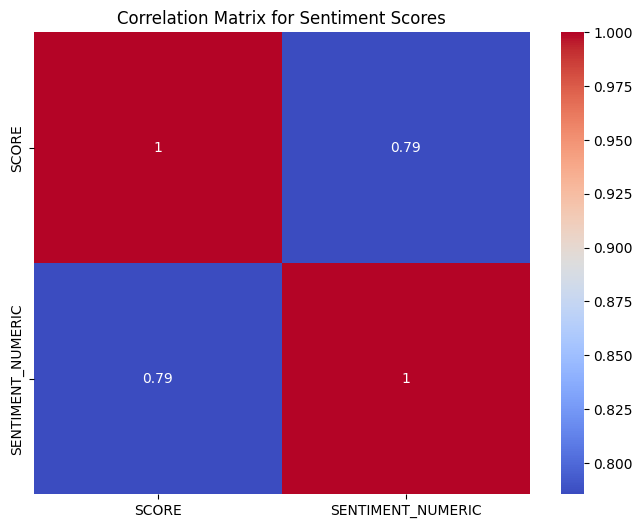

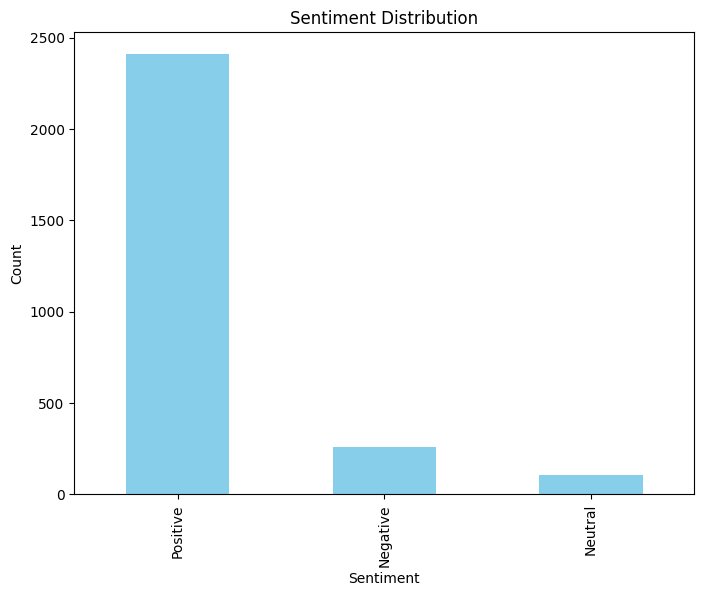

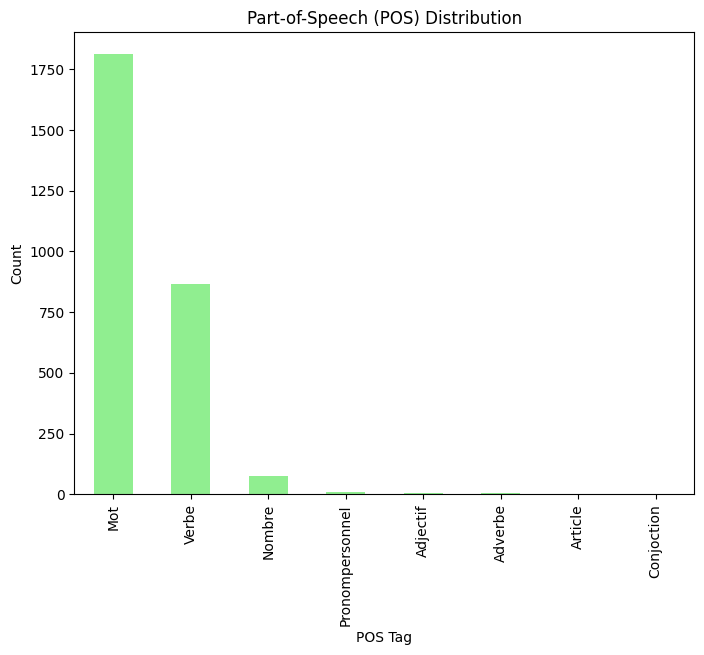

In [11]:
import seaborn as sns

# Correlation Matrix for the sentiment scores
plt.figure(figsize=(8, 6))
correlation_matrix = lexicon_df_cleaned[['SCORE', 'SENTIMENT_NUMERIC']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Sentiment Scores')
plt.show()

# Sentiment Distribution
plt.figure(figsize=(8, 6))
lexicon_df_cleaned['SENTIMENT'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# POS (NATURE) Distribution
plt.figure(figsize=(8, 6))
lexicon_df_cleaned['NATURE'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Part-of-Speech (POS) Distribution')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.show()


<ipython-input-12-13b6b3eb4399>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=lexicon_df_cleaned, x=column, palette='viridis')
<ipython-input-12-13b6b3eb4399>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=lexicon_df_cleaned, x=column, palette='viridis')
<ipython-input-12-13b6b3eb4399>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=lexicon_df_cleaned, x=column, palette='viridis')
<ipython-input-12-13b6b3eb4399>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v

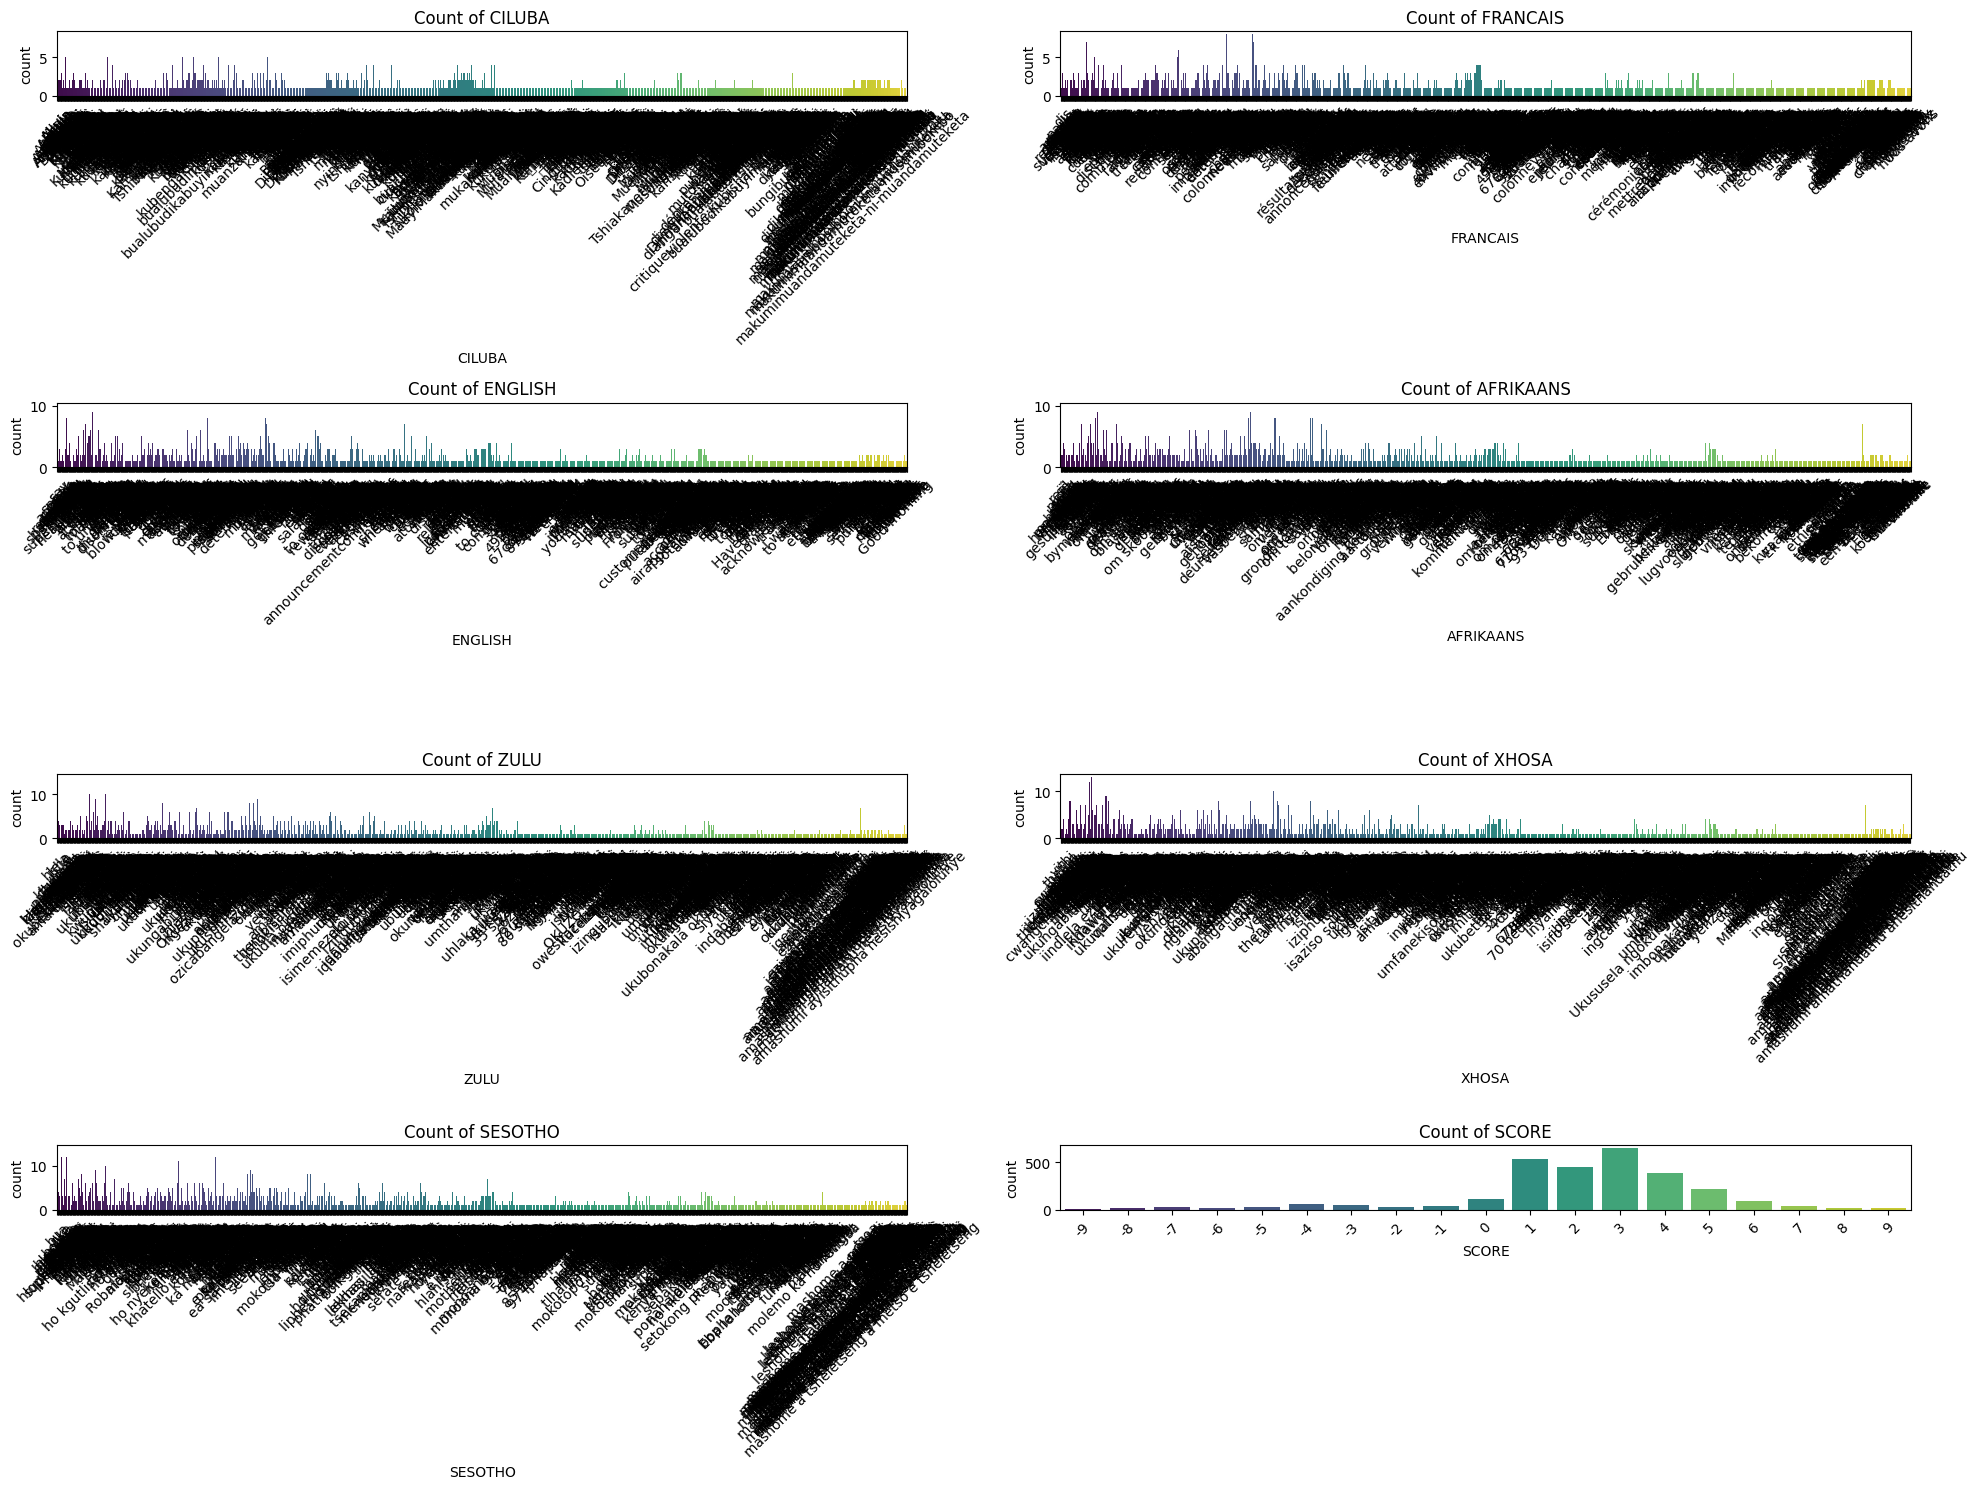

In [12]:
# Data Visualization Part 2
plt.figure(figsize=(20, 15))  # Adjusted figure size for larger, more readable plots

# Define columns to visualize (Languages + score, nature, sentiment)
columns_to_visualize = ['CILUBA', 'FRANCAIS', 'ENGLISH', 'AFRIKAANS', 'ZULU', 'XHOSA', 'SESOTHO', 'SCORE',]

# Create a count plot for each column
for i, column in enumerate(columns_to_visualize):
    plt.subplot(4, 2, i + 1)  # 3 rows and 3 columns for subplots
    sns.countplot(data=lexicon_df_cleaned, x=column, palette='viridis')
    plt.title(f'Count of {column}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability

plt.tight_layout()
plt.show()

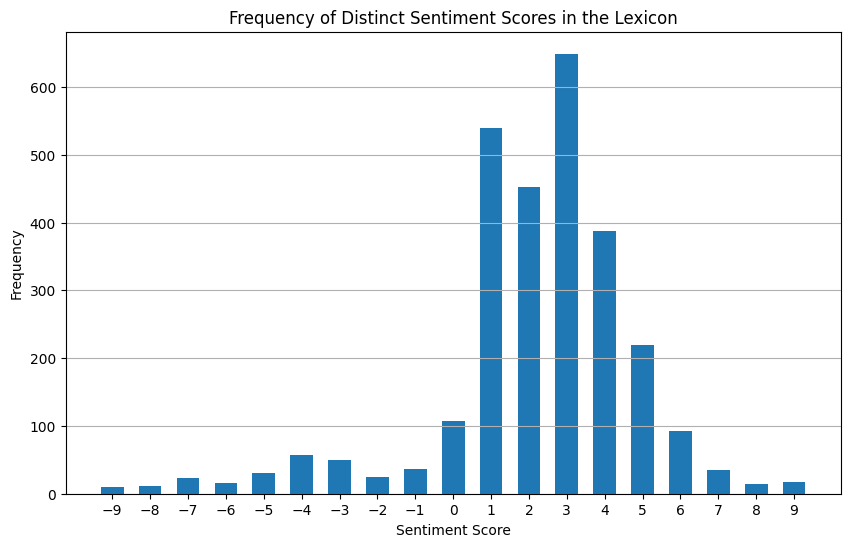

In [13]:
import pandas as pd

# Load the corpus dataset
corpus_df = pd.read_excel('/content/testing_corpus.xlsx')

# Load the lexicon dataset
lexicon_df = pd.read_excel('/content/GroupAssignment3FinalExpandedLexicon.xlsx')

# Let's calculate the frequency of each distinct sentiment score in the dataset and visualize it.

import matplotlib.pyplot as plt

# Count the frequency of each unique sentiment score in the 'SCORE' column
score_counts = lexicon_df['SCORE'].value_counts()

# Plot the frequency of each score
plt.figure(figsize=(10, 6))
plt.bar(score_counts.index, score_counts.values, width=0.6)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Frequency of Distinct Sentiment Scores in the Lexicon')
plt.xticks(score_counts.index)  # Show all score labels on the x-axis
plt.grid(axis='y')

# Show the plot
plt.show()

In [14]:
lexicon_averaged_df = lexicon_df.groupby(['CILUBA', 'FRANCAIS', 'ENGLISH', 'AFRIKAANS', 'ZULU', 'XHOSA', 'SESOTHO'], as_index=False).agg({'SCORE': 'mean'})
df = lexicon_averaged_df
# Function to translate text using the provided lexicon
def translate_text_using_lexicon(text, translation_lexique):
    words = text.lower().split()
    translated_words = [translation_lexique.get(word, word) for word in words]
    translated_text = ' '.join(translated_words)
    return translated_text

# Function to analyze sentiment of translated text
def analyse_sentiment(text, lexique):
    words = text.lower().split()
    word_scores = {word: lexique.get(word, 0) for word in words}
    score = sum(word_scores.values())
    if score > 0.05:
        sentiment = "Positive"
    elif score < -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return score, sentiment, word_scores

# Function to perform translation and sentiment analysis across multiple languages
def process_language_steps(language_steps, texts):
    for step in language_steps:
        print()
        print("#" f"{step['number']}: {step['source_lang']} -> {step['target_lang']}")
        print("-" * 80)

        translation_lexique = step['translation_lexique']
        lexique = step['lexique']

        # Iterate through each sentence in the input text
        for sentence in texts[step['source_lang']]:
            print(f"Original Sentence in {step['source_lang']}: {sentence}")

            # Translate and analyze sentiment
            translated_text = translate_text_using_lexicon(sentence, translation_lexique)
            total_score, sentiment, word_scores = analyse_sentiment(translated_text, lexique)

            # Display the results
            print(f"Translated Text ({step['target_lang']}):", translated_text)
            print("Total Score:", total_score)
            print("Sentiment:", sentiment)
            print("Word Scores:", word_scores)
            print("-" * 80)
            print()

# Example lexicon data (replace with actual data)
#df = df
language_steps = [
    {   'number': '1',
        'source_lang': 'CILUBA',
        'target_lang': 'FRANCAIS',
        'translation_lexique': dict(zip(df['CILUBA'].str.lower(), df['FRANCAIS'])),
        'lexique': dict(zip(df['FRANCAIS'].str.lower(), df['SCORE'])),
    },
    {
        'number': '2',
        'source_lang': 'FRANCAIS',
        'target_lang': 'ENGLISH',
        'translation_lexique': dict(zip(df['FRANCAIS'].str.lower(), df['ENGLISH'])),
        'lexique': dict(zip(df['ENGLISH'].str.lower(), df['SCORE'])),
    },
    {
        'number': '3',
        'source_lang': 'ENGLISH',
        'target_lang': 'AFRIKAANS',
        'translation_lexique': dict(zip(df['ENGLISH'].str.lower(), df['AFRIKAANS'])),
        'lexique': dict(zip(df['AFRIKAANS'].str.lower(), df['SCORE'])),
    },
    {
        'number': '4',
        'source_lang': 'AFRIKAANS',
        'target_lang': 'ZULU',
        'translation_lexique': dict(zip(df['AFRIKAANS'].str.lower(), df['ZULU'])),
        'lexique': dict(zip(df['ZULU'].str.lower(), df['SCORE'])),
    },
    {
        'number': '5',
        'source_lang': 'ZULU',
        'target_lang': 'SESOTHO',
        'translation_lexique': dict(zip(df['ZULU'].str.lower(), df['SESOTHO'])),
        'lexique': dict(zip(df['SESOTHO'].str.lower(), df['SCORE'])),
    },
    {
        'number': '6',
        'source_lang': 'SESOTHO',
        'target_lang': 'XHOSA',
        'translation_lexique': dict(zip(df['SESOTHO'].str.lower(), df['XHOSA'])),
        'lexique': dict(zip(df['XHOSA'].str.lower(), df['SCORE'])),
    },
    {
        'number': '7',
        'source_lang': 'XHOSA',
        'target_lang': 'CILUBA',
        'translation_lexique': dict(zip(df['XHOSA'].str.lower(), df['CILUBA'])),
        'lexique': dict(zip(df['CILUBA'].str.lower(), df['SCORE'])),
    },
]

corps = pd.read_excel('/content/testing_corpus.xlsx')
# Group the dataset by language
grouped_sentences = corps.groupby('language')['sentence'].apply(list).to_dict()

# Now, let's update the `texts` dictionary to reflect the actual content from the file
texts = {
    'CILUBA': grouped_sentences.get('CILUBA', []),
    'FRANCAIS': grouped_sentences.get('FRANCAIS', []),
    'ENGLISH': grouped_sentences.get('ENGLISH', []),
    'AFRIKAANS': grouped_sentences.get('AFRIKAANS', []),
    'ZULU': grouped_sentences.get('ZULU', []),
    'SESOTHO': grouped_sentences.get('SESOTHO', []),
    'XHOSA': grouped_sentences.get('XHOSA', []),
}

# Process translation and sentiment analysis
process_language_steps(language_steps, texts)



#1: CILUBA -> FRANCAIS
--------------------------------------------------------------------------------
Original Sentence in CILUBA: akula buela bansatu
Translated Text (FRANCAIS): parle entre saints
Total Score: 18.0
Sentiment: Positive
Word Scores: {'parle': 2.0, 'entre': 7.0, 'saints': 9.0}
--------------------------------------------------------------------------------

Original Sentence in CILUBA: ambuluja bufuki
Translated Text (FRANCAIS): dépêcher créature
Total Score: 4.0
Sentiment: Positive
Word Scores: {'dépêcher': 2.0, 'créature': 2.0}
--------------------------------------------------------------------------------

Original Sentence in CILUBA: banjelu kusungula bulelela
Translated Text (FRANCAIS): lesanges choisir vérité
Total Score: 9.0
Sentiment: Positive
Word Scores: {'lesanges': 4.0, 'choisir': 1.0, 'vérité': 4.0}
--------------------------------------------------------------------------------


#2: FRANCAIS -> ENGLISH
--------------------------------------------------


Evaluating Logistic Regression with SMOTE balancing...
Classification Report for LogisticRegression:

              precision    recall  f1-score   support

          -1       0.50      0.21      0.29        73
           0       1.00      0.06      0.11        34
           1       0.89      0.98      0.93       726

    accuracy                           0.87       833
   macro avg       0.80      0.41      0.44       833
weighted avg       0.86      0.87      0.84       833



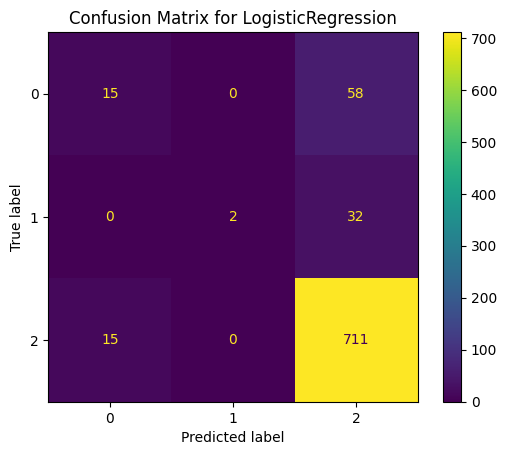

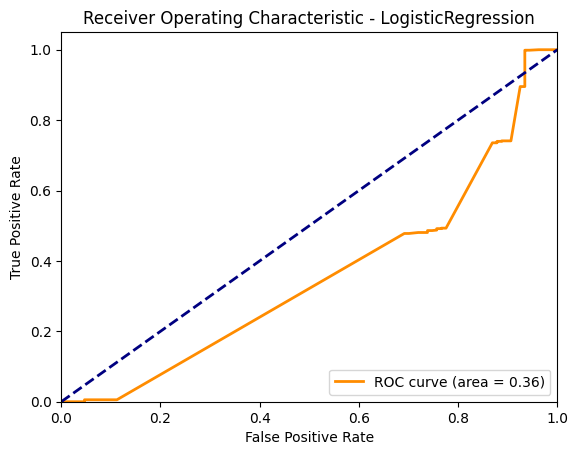


Evaluating Random Forest with SMOTE balancing...
Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

          -1       0.54      0.26      0.35        73
           0       1.00      0.15      0.26        34
           1       0.90      0.98      0.93       726

    accuracy                           0.88       833
   macro avg       0.81      0.46      0.51       833
weighted avg       0.87      0.88      0.86       833



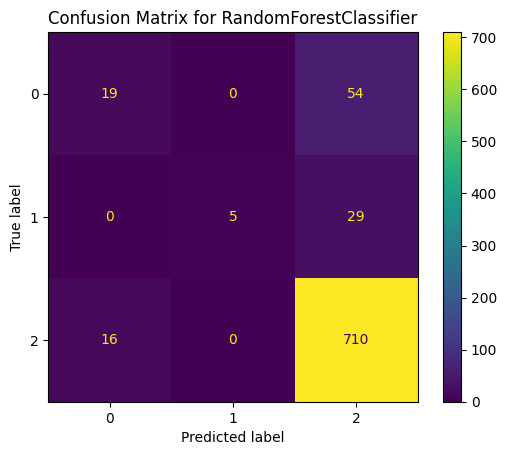

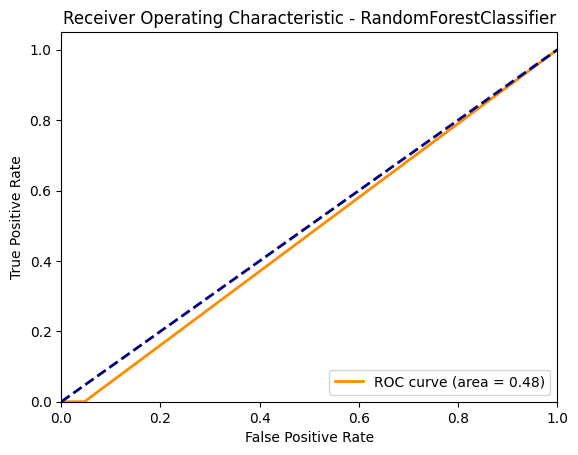


Evaluating SVM with SMOTE balancing...
Classification Report for SVC:

              precision    recall  f1-score   support

          -1       0.51      0.32      0.39        73
           0       1.00      0.09      0.16        34
           1       0.90      0.97      0.93       726

    accuracy                           0.88       833
   macro avg       0.80      0.46      0.49       833
weighted avg       0.87      0.88      0.85       833



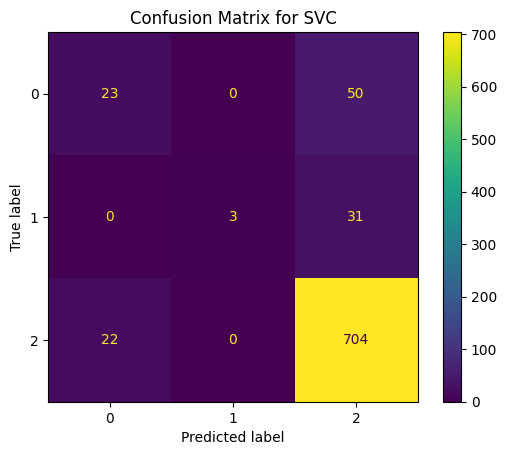

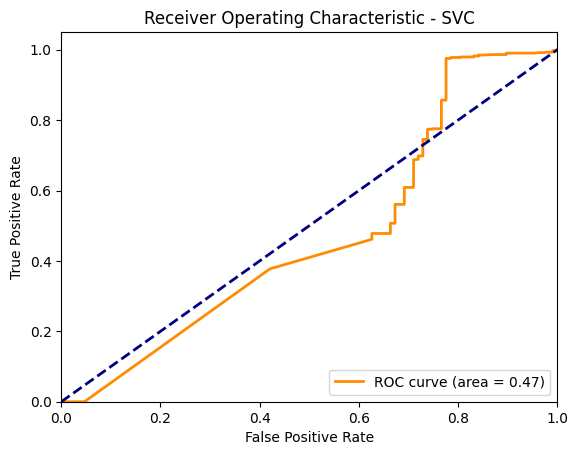


Evaluating Decision Tree with SMOTE balancing...
Classification Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

          -1       0.55      0.36      0.43        73
           0       1.00      0.12      0.21        34
           1       0.90      0.97      0.94       726

    accuracy                           0.88       833
   macro avg       0.82      0.48      0.53       833
weighted avg       0.88      0.88      0.86       833



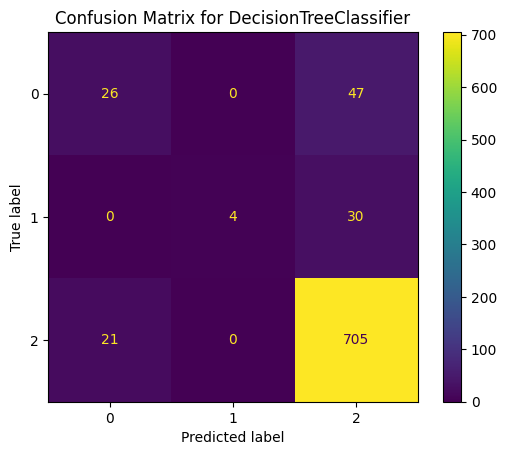

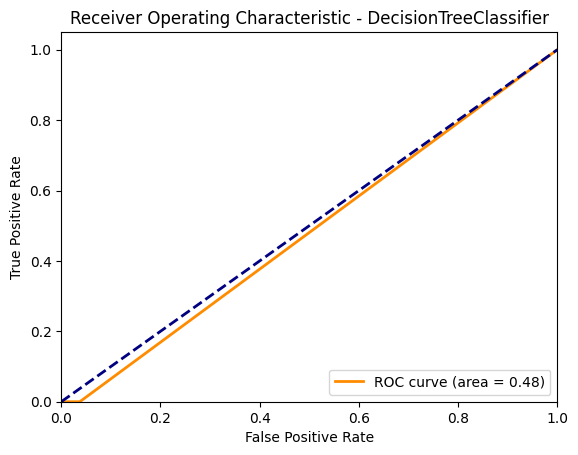


Evaluating Naive Bayes with SMOTE balancing...
Classification Report for MultinomialNB:

              precision    recall  f1-score   support

          -1       0.14      0.86      0.24        73
           0       1.00      0.15      0.26        34
           1       0.97      0.49      0.65       726

    accuracy                           0.51       833
   macro avg       0.70      0.50      0.38       833
weighted avg       0.90      0.51      0.60       833



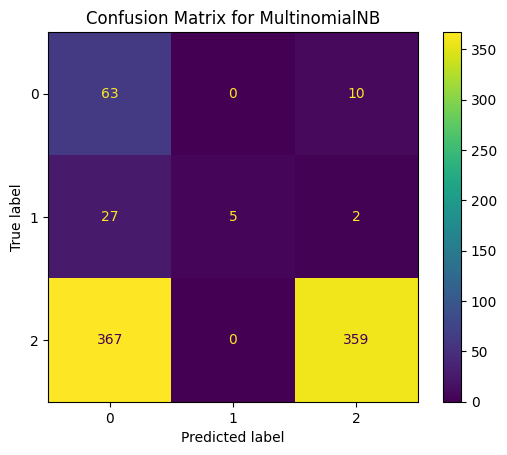

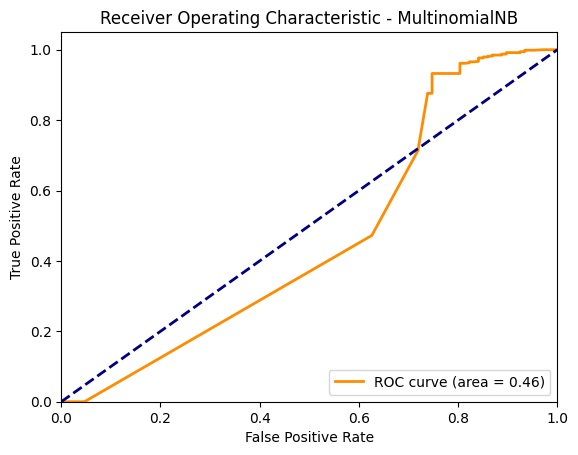

In [15]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Assuming lexicon_df is your original DataFrame with the 'SENTIMENT_NUMERIC' column
lexicon_averaged_df = lexicon_df.groupby(['CILUBA', 'FRANCAIS', 'ENGLISH', 'AFRIKAANS', 'ZULU', 'XHOSA', 'SESOTHO'], as_index=False).agg({'SCORE': 'mean'})
df = lexicon_averaged_df

# Before proceeding, merge the 'SENTIMENT_NUMERIC' column back into df
# Assuming 'lexicon_df' has 'CILUBA', 'FRANCAIS', etc., columns to merge on
df = pd.merge(df, lexicon_df[['CILUBA', 'FRANCAIS', 'ENGLISH', 'AFRIKAANS', 'ZULU', 'XHOSA', 'SESOTHO', 'SENTIMENT_NUMERIC']],
              on=['CILUBA', 'FRANCAIS', 'ENGLISH', 'AFRIKAANS', 'ZULU', 'XHOSA', 'SESOTHO'],
              how='left')

# Step 1: Use TfidfVectorizer instead of CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['FRANCAIS'])  # Using 'FRANCAIS' as the feature text

# Step 2: Prepare the target column ('SENTIMENT_NUMERIC')
y = df['SENTIMENT_NUMERIC'] #Now this should work!

# ... (rest of your code)

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Step 5: Retrain models on the balanced dataset
# Train Logistic Regression model
lr_model_balanced = LogisticRegression(max_iter=1000)
lr_model_balanced.fit(X_train_balanced, y_train_balanced)

# Train Random Forest model
rf_model_balanced = RandomForestClassifier()
rf_model_balanced.fit(X_train_balanced, y_train_balanced)

# Train Support Vector Machine (SVM)
svm_model_balanced = SVC(probability=True)
svm_model_balanced.fit(X_train_balanced, y_train_balanced)

# Decision Tree
dt_model_balanced = DecisionTreeClassifier(random_state=42)
dt_model_balanced.fit(X_train_balanced, y_train_balanced)

# Naive Bayes
nb_model_balanced = MultinomialNB()
nb_model_balanced.fit(X_train_balanced, y_train_balanced)



# Function to evaluate model performance with detailed metrics
def evaluate_model_detailed(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Classification Report for {model.__class__.__name__}:\n")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

    # ROC curve and AUC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model.__class__.__name__}')
    plt.legend(loc="lower right")
    plt.show()

# Step 6: Evaluate the balanced models
models_balanced = {
    "Logistic Regression": lr_model_balanced,
    "Random Forest": rf_model_balanced,
    "SVM": svm_model_balanced,
    "Decision Tree": dt_model_balanced,
    "Naive Bayes": nb_model_balanced
}

# Evaluate models with balanced data
for model_name, model in models_balanced.items():
    print(f"\nEvaluating {model_name} with SMOTE balancing...")
    evaluate_model_detailed(model, X_test, y_test)
